## ENUNCIADO EJERCICIO

* Dataset Airbnb NYC https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data AB_NYC_2019.csv
    * Quitar columnas: id, host_id, host_name
    * Fecha: probar a descomponer la fecha en campos año mes y día con pandas es decir, en 3 columnas, por ejemplo usando to_datetime de pandas y los accesores de fecha para extraer año mes y día.

* EDAs (10%) (menos foco para este módulo)
    * univariantes: histogramas boxplot countplot
    * bivariantes: scatterplot
    * multivariante: corr en heatmap, pairplot
* Preprocesados (20%)
    * numéricas: imputer, scaler, transformer
    * categóricas: imputer, encoder
    * Requisito: hacer los preprocesados con Scikit Learn en lugar de métodos de pandas
* clustering y siluetas (10 %)
    * Crear una columna cluster usando KMeans o cualquier otro algoritmo de Clustering
    * Usar esa columna para hacer algún gráfico EDA como hue para colorear con scatterplot
* feature selection (10%)
    * SelectKBest para filtrar las mejores columnas y probar
    * PCA 
* Regresión (20%):
    * Predecir la columna 'price'
* Clasificación multiclase (20%)
    * Predecir la columna 'room_type'
* Comparar resultados de modelos con validación cruzada (10 %)
    * Mostrar un dataframe de resultados con las métricas calculadas
    * Opcional: mostrar boxplot de los resultados de validación cruzada como tiempos de ejecución y predicción y métricas

* Opcional:
    * Uso de pipelines opcional:
        * Opción 1: hacer las transformaciones por separado manualmente
        * Opción 2: hacer las transformaciones con pipelines
        * Opción 3: una primera parte con transformaciones manuales y una segunda parte con Pipeline
        * En ambos casos sería interesante calcular las métricas para ver qué técnicas de preprocesado van mejor
    * Vectorizar la columna texto 'name' y usar TruncatedSVD
    * Clasificación multiclase 'room_type' con TensorFlow-Keras
    * SMOTE si hay desbalanceo para el problema de clasificación multiclase 'room_type'



In [35]:

import seaborn as sns 
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.svm import SVR

In [44]:
df = pd.read_csv('AB_NYC_2019.csv').drop(['id','host_id','host_name','last_review'], axis=1)
df.head(3)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   neighbourhood_group             48895 non-null  object 
 2   neighbourhood                   48895 non-null  object 
 3   latitude                        48895 non-null  float64
 4   longitude                       48895 non-null  float64
 5   room_type                       48895 non-null  object 
 6   price                           48895 non-null  int64  
 7   minimum_nights                  48895 non-null  int64  
 8   number_of_reviews               48895 non-null  int64  
 9   last_review                     38843 non-null  object 
 10  reviews_per_month               38843 non-null  float64
 11  calculated_host_listings_count  48895 non-null  int64  
 12  availability_365                

In [30]:
df['name'] = df['name'].astype('category')
df['neighbourhood_group'] = df['neighbourhood_group'].astype('category')
df['neighbourhood'] = df['neighbourhood'].astype('category')
df['room_type'] = df['room_type'].astype('category')
df['last_review'] = df['last_review'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   name                            48879 non-null  category
 1   neighbourhood_group             48895 non-null  category
 2   neighbourhood                   48895 non-null  category
 3   latitude                        48895 non-null  float64 
 4   longitude                       48895 non-null  float64 
 5   room_type                       48895 non-null  category
 6   price                           48895 non-null  int64   
 7   minimum_nights                  48895 non-null  int64   
 8   number_of_reviews               48895 non-null  int64   
 9   last_review                     38843 non-null  category
 10  reviews_per_month               38843 non-null  float64 
 11  calculated_host_listings_count  48895 non-null  int64   
 12  availability_365  

In [50]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_imputed.head(5)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.9419,Private room,150,3,0,0,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.1,1,0


In [46]:
# df_imputed['last_review'] = pd.to_datetime(df_imputed['last_review'])
# df_imputed['year'] = df['last_review'].dt.year
# df_imputed['month'] = df['last_review'].dt.month
# df_imputed['day'] = df['last_review'].dt.day
# df_imputed.head(3)

In [ ]:
df_imputed.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [51]:
df_imputed.isna().sum()

name                              0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

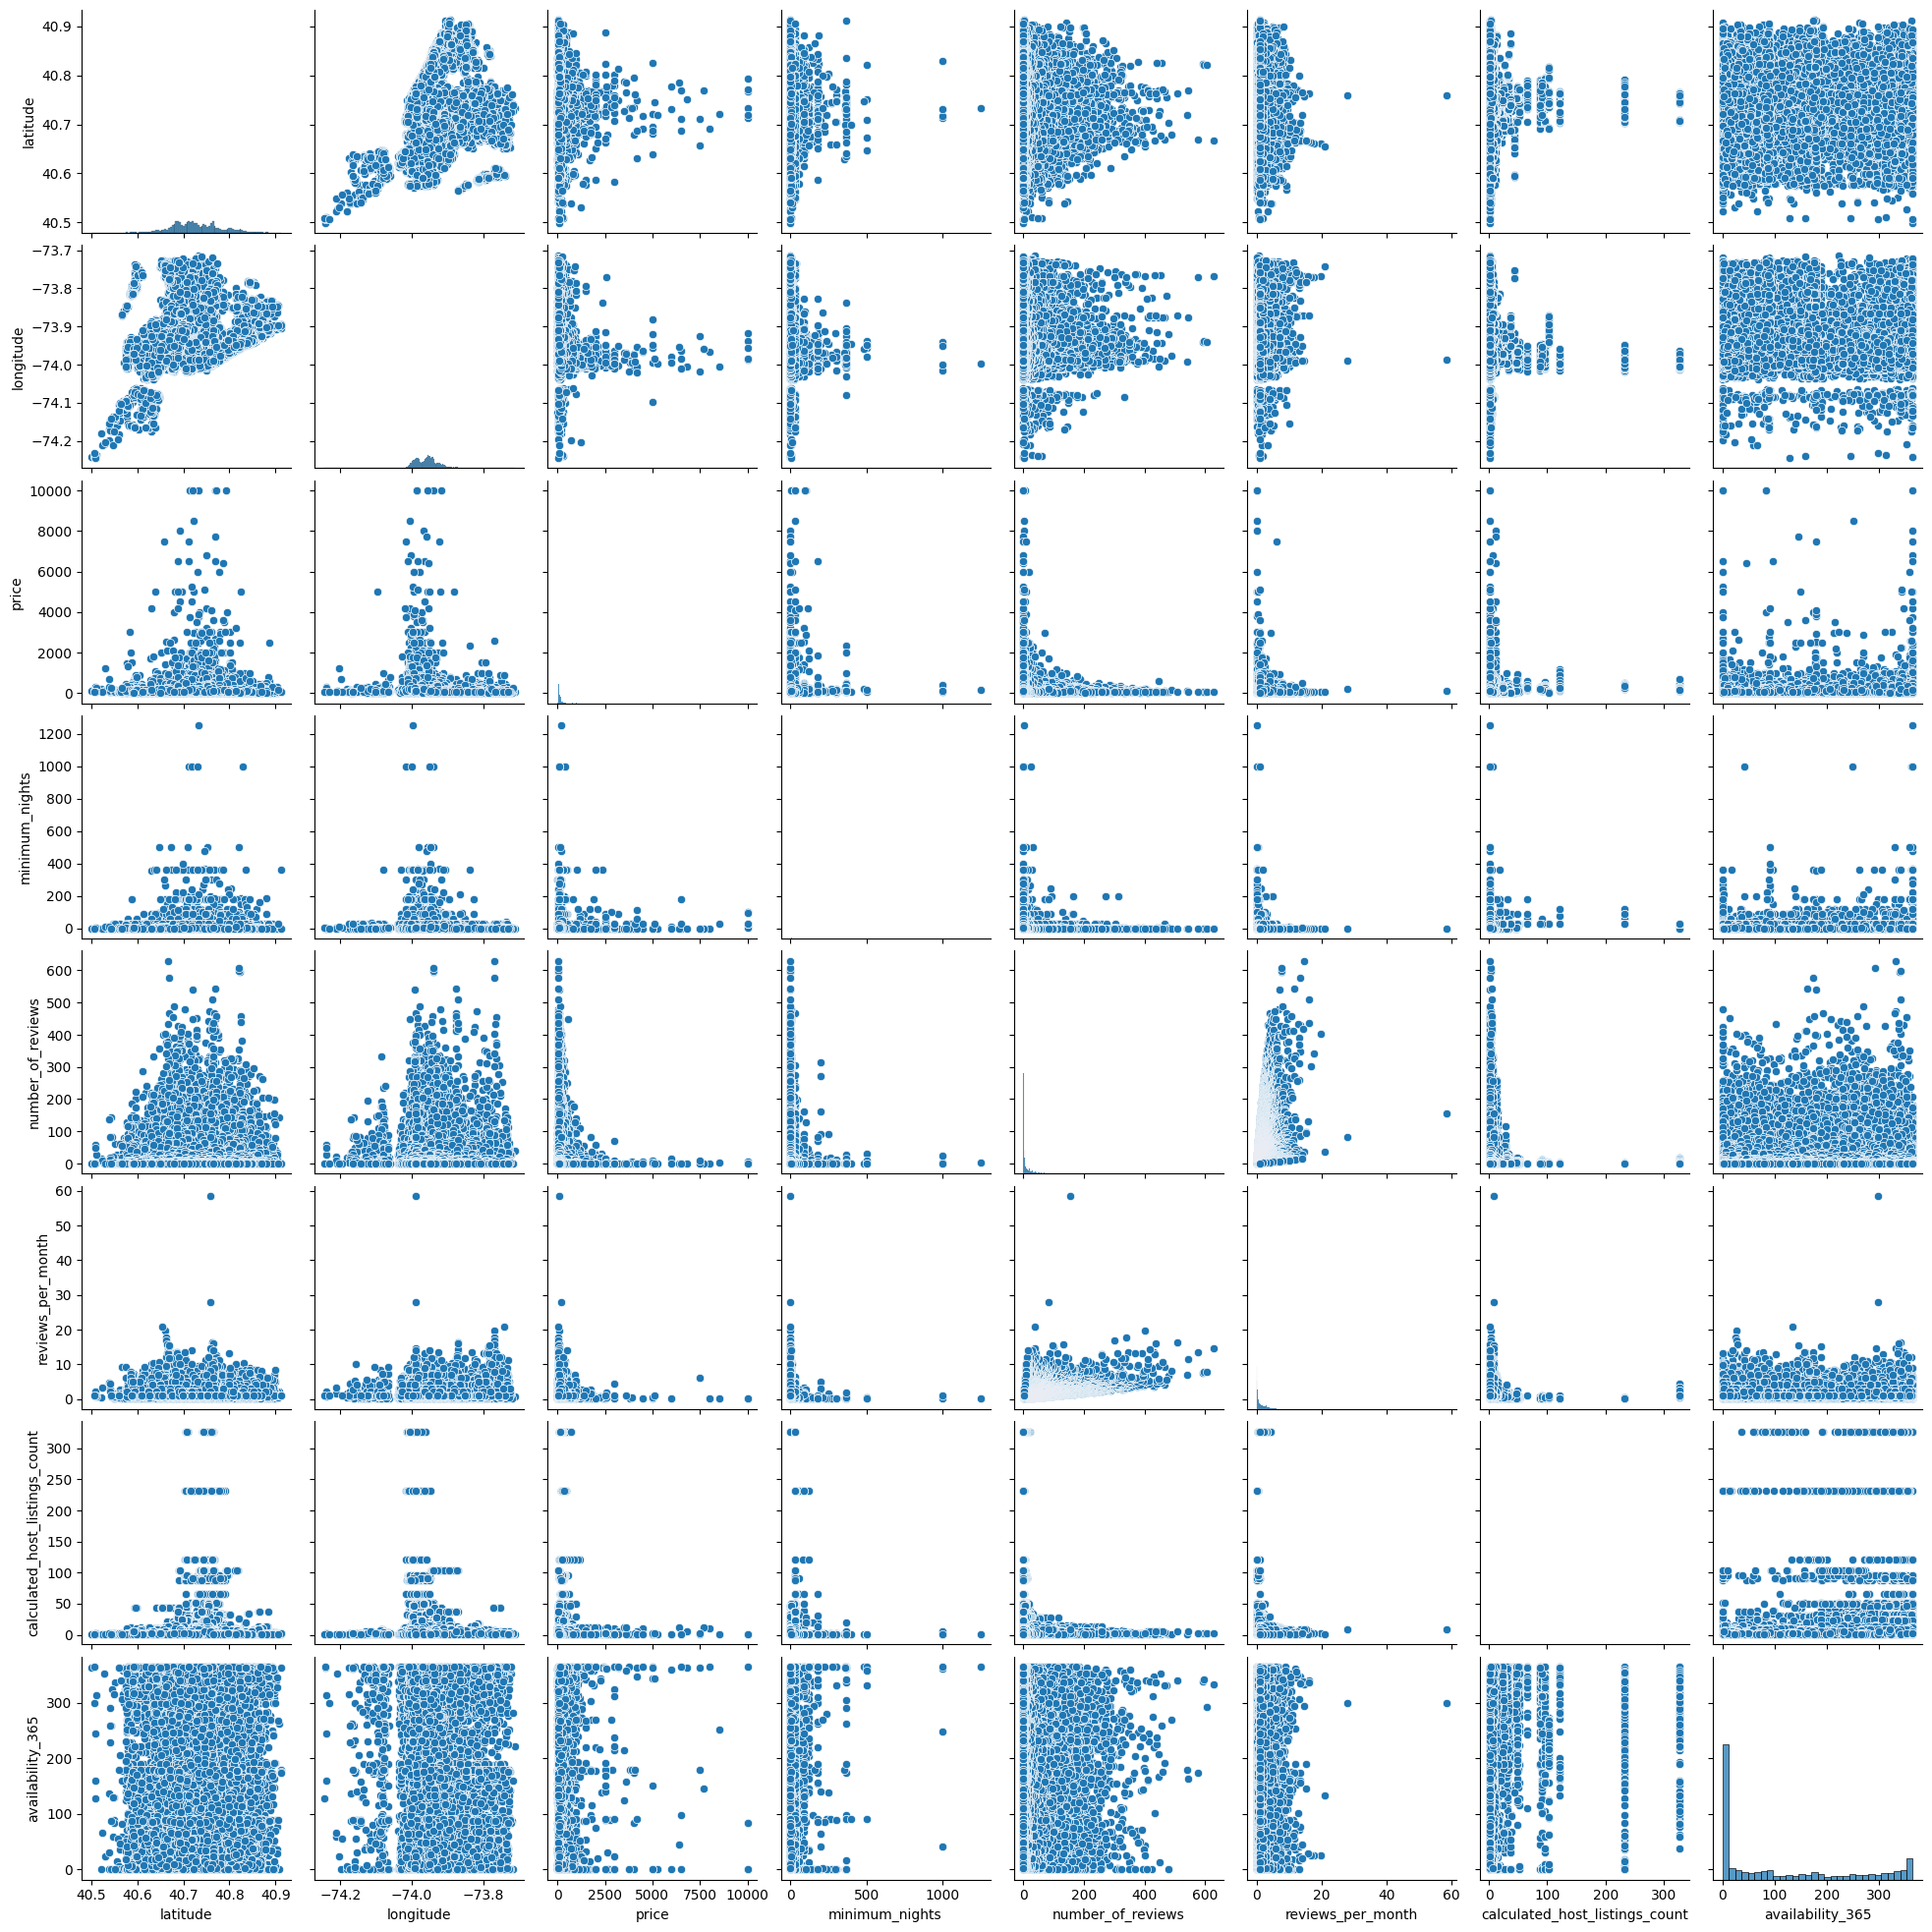

In [ ]:
sns.pairplot(df_imputed)

In [58]:
#sns.heatmap(df_imputed.corr(numeric_only=True), annot=True, cmap='viridis' )

In [56]:
X= df_imputed.drop('price', axis=1)
y= df_imputed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

df_resultados = pd.DataFrame(columns=['Modelo', 'Preprocesado', 'R2', 'MAE', 'RMSE', 'MAPE'])

def calculate_metrics(preprocessor_name, X_train, X_test, y_train, y_test):
    models = {
        'LinearRegression': LinearRegression(),
        'KNN': KNeighborsRegressor(),
        'SVR': SVR(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42)
    }
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df_resultados.loc[len(df_resultados)] = [model_name, preprocessor_name, r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred),root_mean_squared_error(y_test, y_pred),mean_absolute_percentage_error(y_test, y_pred)]
    
    return df_resultados.sort_values('R2', ascending=False)

In [57]:
calculate_metrics('Sin preprocesado', X_train, X_test, y_train, y_test)

ValueError: could not convert string to float: 'Bushwick Rustic Loft'